# MIT AJL Team 16 Notebook

@Lee Mabhena
@Shahadah Manzer
@Ha Linh Nguyen

---


This project is part of the Spring 2025 AI Studio, a collaboration between Break Through Tech and the Algorithmic Justice League (AJL). The goal is to develop an inclusive machine learning model that can classify 21 dermatological conditions across a diverse range of skin tones. Motivated by the fact that many existing dermatology AI tools underperform for people with darker skin due to biased training data, this challenge encourages us to build not just accurate models, but fair and explainable ones. Our approach involves leveraging techniques such as data augmentation, transfer learning, and fairness analysis to reduce disparities in model performance. In addition to submitting predictions to the Kaggle leaderboard, we will also reflect on ethical considerations and the impact of our work in a final write-up.

---

## 1. Import Necessary Libraries

In [8]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.densenet import DenseNet201
import seaborn as sns


%matplotlib inline
import matplotlib.pyplot as plt

## 2. Data Analysis and Preprocessing

In [2]:
TRAIN_DIR = '/kaggle/input/bttai-ajl-2025/train/train'
TEST_DIR = '/kaggle/input/bttai-ajl-2025/test/test'
TEST_CSV = '/kaggle/input/bttai-ajl-2025/test.csv' 
TRAIN_CSV = '/kaggle/input/bttai-ajl-2025/train.csv' 
SUBMISSION_CSV = 'submission.csv'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 50
EPOCHS_FINE_TUNE = 20

In [4]:
# ---------------------------
# 2. Create Training and Validation Generators using flow_from_directory
# ---------------------------
# Since the training images are organized by class (each folder name is the label),
# we can use the "validation_split" argument to automatically reserve a portion of the data.
# Image data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data used for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator from the same training directory
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2300 images belonging to 21 classes.
Found 560 images belonging to 21 classes.


In [5]:
train_data = pd.read_csv(TRAIN_CSV)
print(train_data.head())

                            md5hash  fitzpatrick_scale  fitzpatrick_centaur  \
0  fd06d13de341cc75ad679916c5d7e6a6                  4                    4   
1  a4bb4e5206c4e89a303f470576fc5253                  1                    1   
2  c94ce27e389f96bda998e7c3fa5c4a2e                  5                    5   
3  ebcf2b50dd943c700d4e2b586fcd4425                  3                    3   
4  c77d6c895f05fea73a8f3704307036c0                  1                    1   

                              label nine_partition_label  \
0                 prurigo-nodularis     benign-epidermal   
1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                            keloid         inflammatory   
3              basal-cell-carcinoma  malignant-epidermal   
4                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  
0                benign           NaN         34  
1             malignant           NaN         12  
2        no

In [6]:
print("Dataset shape:", train_data.shape)
print("\nMissing values:\n", train_data.isnull().sum())
print("\nData types:\n", train_data.dtypes)

Dataset shape: (2860, 8)

Missing values:
 md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
dtype: int64

Data types:
 md5hash                  object
fitzpatrick_scale         int64
fitzpatrick_centaur       int64
label                    object
nine_partition_label     object
three_partition_label    object
qc                       object
ddi_scale                 int64
dtype: object


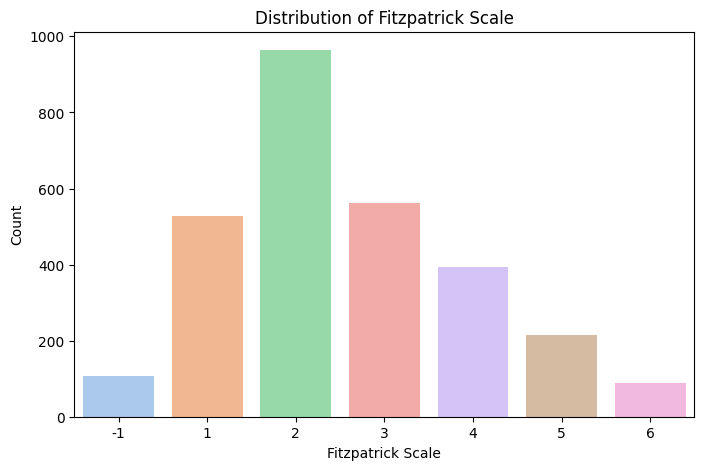

In [9]:
# Distribution of Fitzpatrick scale
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='fitzpatrick_scale', palette='pastel')
plt.title('Distribution of Fitzpatrick Scale')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Count')
plt.show()

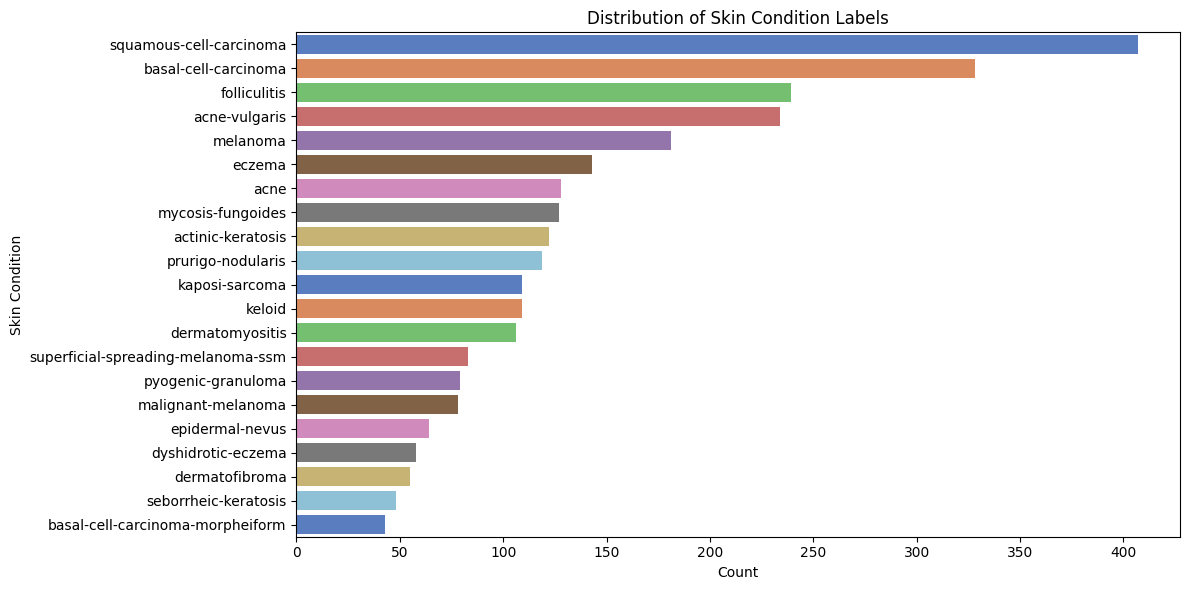

In [10]:
# Distribution of labels (21 skin conditions)
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, y='label', order=train_data['label'].value_counts().index, palette='muted')
plt.title('Distribution of Skin Condition Labels')
plt.xlabel('Count')
plt.ylabel('Skin Condition')
plt.tight_layout()
plt.show()

There is a large class imbalance across the different skin conditions and fitzpatrick scale, thus measures should be taken in training the models to cater for the class imbalance.

## 3. Training the model

We are making use of two models, InceptionV3 and Densenet201 as our base models for the transfer learning. Then we select the model which acchieves the highest f1 score on validation data as the model to use to make the submission data.

In [4]:
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
print(len(pre_trained_model.layers))

311


In [6]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output)
last_output = last_layer.output

last layer output shape: <KerasTensor shape=(None, 5, 5, 2048), dtype=float32, sparse=False, name=keras_tensor_310>


In [7]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(21, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
#optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [8]:
# Use the class weights to cater for class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_indices = train_generator.classes  

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.06333795654184, 1: 0.5825734549138805, 2: 1.1175898931000972, 3: 0.416440340394713, 4: 3.129251700680272, 5: 2.4891774891774894, 6: 1.288515406162465, 7: 2.330293819655522, 8: 0.9523809523809523, 9: 2.1062271062271063, 10: 0.5704365079365079, 11: 1.2445887445887447, 12: 1.2445887445887447, 13: 1.7384731670445956, 14: 0.7553366174055829, 15: 1.0737628384687208, 16: 1.1408730158730158, 17: 1.7113095238095237, 18: 2.808302808302808, 19: 0.3359626059012562, 20: 1.634683724235963}


In [9]:
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    #validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights_dict
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 864ms/step - accuracy: 0.0566 - loss: 5.5052 - val_accuracy: 0.1089 - val_loss: 2.9344
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 484ms/step - accuracy: 0.0928 - loss: 3.0890 - val_accuracy: 0.1286 - val_loss: 2.9003
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.1218 - loss: 2.9321 - val_accuracy: 0.1554 - val_loss: 2.8374
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 482ms/step - accuracy: 0.1469 - loss: 2.8955 - val_accuracy: 0.1857 - val_loss: 2.7487
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - accuracy: 0.1513 - loss: 2.8075 - val_accuracy: 0.1839 - val_loss: 2.7236
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 490ms/step - accuracy: 0.1623 - loss: 2.7793 - val_accuracy: 0.1875 - val_loss: 2.6654
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - accuracy: 0.1860 - loss: 2.7192 - val_accuracy: 0.2286 - val_loss: 2.5651
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.2105 - loss: 2.6159 - val_accuracy: 0.217

In [ ]:
validation_generator.reset()
val_preds = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = validation_generator.classes

import sklearn
# Calculate the weighted average F1 score.
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
print("Validation Weighted F1 Score: {:.4f}".format(f1))

Print a detailed classification report.
labels = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=labels))

Fine tune the model by unfreezing all the layers and retraining.

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [12]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [14]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction]
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - acc: 0.1370 - loss: 2.9221 - val_acc: 0.2911 - val_loss: 2.3071 - learning_rate: 1.0000e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - acc: 0.2644 - loss: 2.3602 - val_acc: 0.3179 - val_loss: 2.2157 - learning_rate: 1.0000e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 516ms/step - acc: 0.3866 - loss: 1.8877 - val_acc: 0.3750 - val_loss: 2.1180 - learning_rate: 1.0000e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - acc: 0.4565 - loss: 1.5921 - val_acc: 0.3964 - val_loss: 2.0066 - learning_rate: 1.0000e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 515ms/step - acc: 0.5389 - loss: 1.2898 - val_acc: 0.4018 - val_loss: 2.0986 - learning_rate: 1.0000e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - acc: 0.6042 - loss: 1.0749 - val_acc: 0.4000 - val_loss: 2.0982 - learning_rate: 1.0000e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 516ms/step - acc: 0.6337 - loss: 0.9065 - val_acc: 0.4411 - val_loss: 1.9437 -

In [ ]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
validation_generator.reset()
val_preds = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = validation_generator.classes

import sklearn
# Calculate the weighted average F1 score.
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
print("Validation Weighted F1 Score: {:.4f}".format(f1))

#### Train the Densenet201 model

In [ ]:
denseNet = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [ ]:
for layer in denseNet.layers:
    layer.trainable = False

In [ ]:
denseNet_last_layer = denseNet.get_layer('relu')
print('last layer output shape:', denseNet_last_layer.output)
denseNet_last_output = denseNet_last_layer.output

In [ ]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.5)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(21, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(denseNet.input, x_denseNet)
optimizer = Adam(learning_rate=0.0001)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
denseNet_model.summary()

In [ ]:
denseNet_history = denseNet_model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    #validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights_dict
)

In [ ]:
validation_generator.reset()
val_preds = denseNet_model.predict(validation_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = validation_generator.classes

import sklearn
# Calculate the weighted average F1 score.
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
print("Validation Weighted F1 Score: {:.4f}".format(f1))

In [ ]:
for layer in denseNet.layers:
    layer.trainable = False

In [ ]:
denseNet_history = denseNet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction]
)

## 4. Generate submission file on the best perfoming model.

In [ ]:
TEST_CSV = '/kaggle/input/bttai-ajl-2025/test.csv' 
test_df = pd.read_csv(TEST_CSV)
test_df['filepath'] = test_df['md5hash'].apply(lambda x: os.path.join(TEST_DIR, f"{x}.jpg"))

# Optionally, filter out missing files:
test_df = test_df[test_df['filepath'].apply(os.path.exists)]
if test_df.empty:
    raise ValueError("No valid test image files found. Check your TEST_DIR and file naming convention.")

# Create a test data generator (no labels).
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Predict on test images.
test_preds = denseNet_model.predict(test_generator, verbose=1)
test_label_indices = np.argmax(test_preds, axis=1)

# Map indices back to label names.
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
test_labels = [inv_class_indices[idx] for idx in test_label_indices]

# Create the submission DataFrame.
submission_df = pd.DataFrame({
    'md5hash': test_df['md5hash'],
    'label': test_labels
})
submission_df.to_csv(SUBMISSION_CSV, index=False)
print(f"Submission file saved to {SUBMISSION_CSV}")